In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Fields

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** 

    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

##### Load Clean and Dummy-ize our variables

In [2]:
train = pd.read_csv('data/train.csv')
hold_out = pd.read_csv('data/test.csv')

def clean_frame(df):
    seasons = {'spring':1, 'summer':2, 'winter':3, 'fall':4}
    for season in seasons.iterkeys():
        df[season] = df['season'].isin([seasons[season]])

    weather_types = {'clear':1, 'mist':2, 'light':3, 'heavy':4}
    for weather in weather_types:
        df[weather] = df['weather'].isin([weather_types[weather]])

    ### drop stuff we don't need ###
    df = df.drop(['season', 'weather'], axis=1)
    df = df.set_index('datetime')

    ### Rearrange columns
    cols = df.columns
    cols = cols[6:9].append(cols[:6]).append(cols[9:])
    df = df[cols]
    df.index = pd.to_datetime(df.index)
    return df

train = clean_frame(train)

### Collinearity

Weather, humidity, temperature are collinear with the seasons, so any time series analysis would need to account for this effect. 

I suspect that weather's effect on whether people will use a bike are somewhat transient.  70 degrees feels like a great day for a bike ride, but if it's been 40 degrees for weeks, a 55 degree day may also feel similar.  

In [3]:
def pairplot(train, pair_variables, y_var):
    g = sns.pairplot(train[pair_variables],
                 kind='reg',
                 x_vars=pair_variables,
                y_vars=y_var,
                size=5)
    g.set(ylim=(0, 1500))


# Observations: Which Variables effect the outcome?

### Count against weather stats

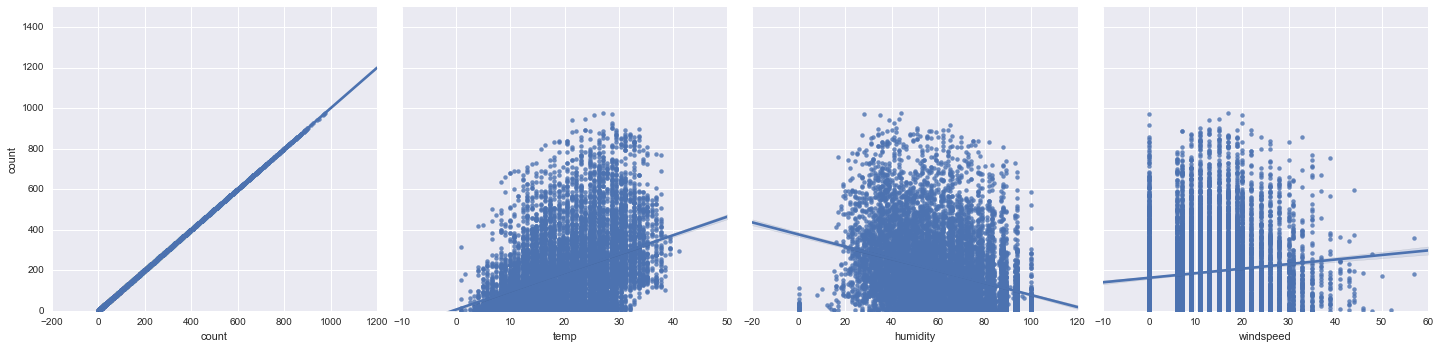

In [4]:
y = 'count'
pairplot(train, [y, 'temp', 'humidity', 'windspeed'], y_var=[y])

### Count against Weather Type

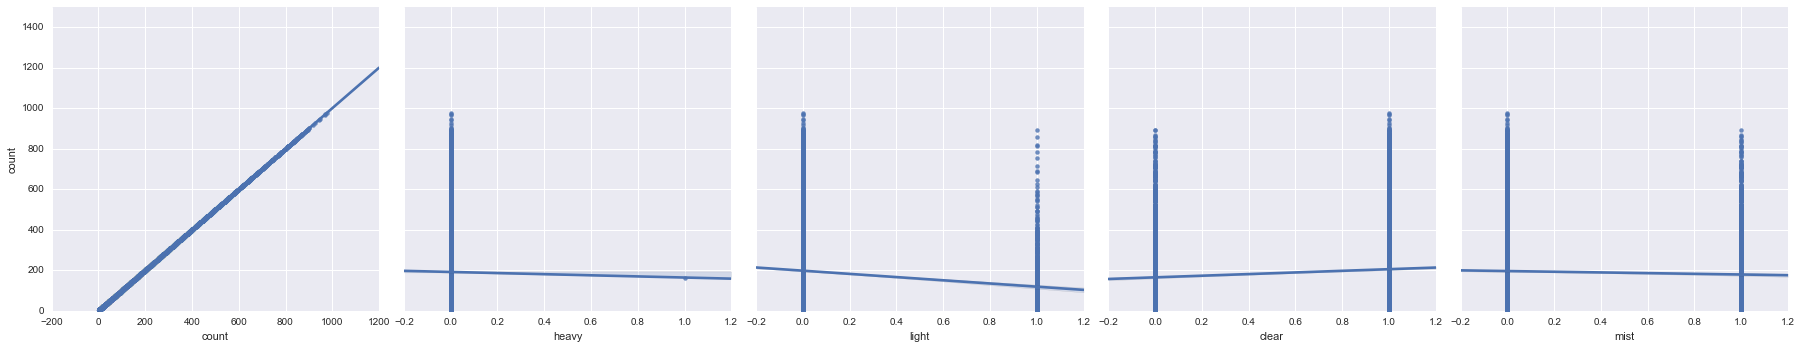

In [5]:
y = 'count'
pairplot(train, [y, 'heavy', 'light', 'clear', 'mist'], y_var=[y])

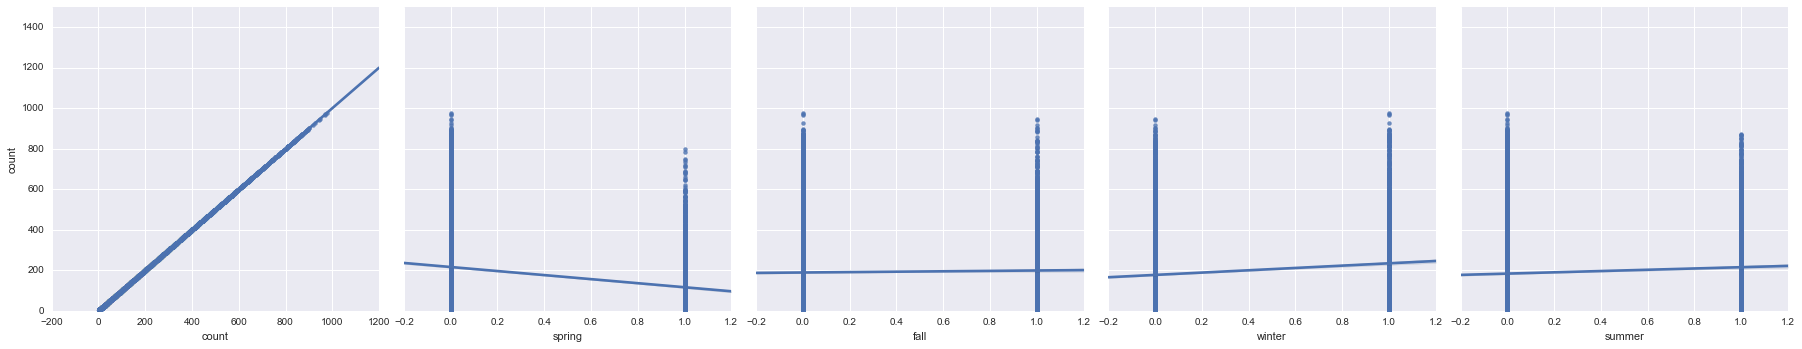

In [6]:
y = 'count'
pairplot(train, [y, 'spring', 'fall', 'winter', 'summer'], y_var=[y])

##### Let's look at how bike usage varies with time.  

In [8]:
train_wk_day = train[train['workingday'] == 1]
train_wknd = train[train['workingday'] == 0]

''

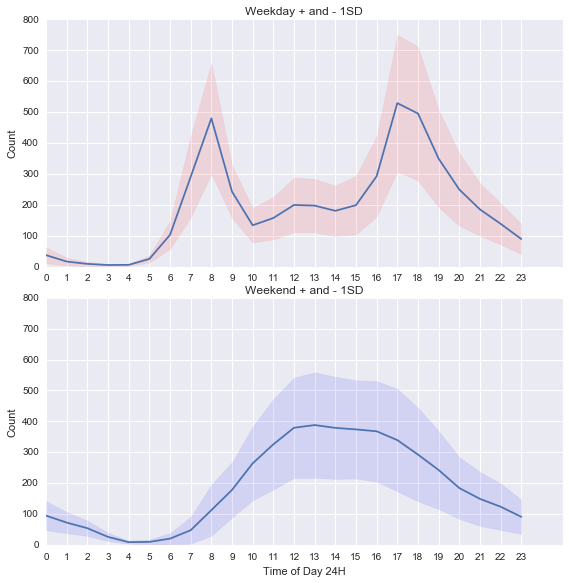

In [9]:
train_hours = train_wk_day.groupby(train_wk_day.index.hour)[['count', 'registered', 'casual']].mean()
std = train_wk_day.groupby(train_wk_day.index.hour)['count'].std()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1)
ax.plot(train_hours.drop(['registered', 'casual'], axis=1))

ax.fill_between(train_hours.index, train_hours['count'] - std,
                 train_hours['count'] + std, alpha=0.1, 
                                                    color="r")

plt.xticks(range(0, 24, 1))
plt.ylim(0, 800)
plt.title('Weekday + and - 1SD')
plt.ylabel('Count')

### Second Plot
train_wknd_hours = train_wknd.groupby(train_wknd.index.hour)[['count','registered','casual']].mean()
std_wknd = train_wknd.groupby(train_wknd.index.hour)['count'].std()

# train_wknd_hours.plot(xticks=range(0,23,1), ylim=(0, 600))
ax1 = fig.add_subplot(2, 1, 2)
ax1.plot(train_wknd_hours.drop(['registered', 'casual'], axis=1))
ax1.fill_between(train_wknd_hours.index, train_wknd_hours['count'] - std_wknd,
                 train_wknd_hours['count'] + std_wknd, alpha=0.1, 
                                                    color="b")


plt.xticks(range(0, 24, 1))
plt.ylim(0,800)
fig.tight_layout()
plt.xlabel('Time of Day 24H')
plt.title('Weekend + and - 1SD')
plt.ylabel('Count')
plt.savefig('/Users/ryanlambert/Desktop/bikes_per_hour.png')
;

# Observations

Based on what I have seen thus far I'm going to include hour of day as a dummy variable.  

There is a clear signal that is a function of what time of day it is.  

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(X, y, estimator, param_range=np.logspace(-6, 6, 4)):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name='ridge__alpha',
        param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    ax.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    ax.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    plt.title("Validation Curve Multiple Regression")
    plt.xlabel("Alpha")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.legend(loc="best")
    plt.show()

def resid_plot(X, y, est):
    y_pred = est.predict(X)
    residuals = y - y_pred

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(y, residuals)
    plt.title('Residuals VS Fitted')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.hist(residuals, orientation='horizontal')
    plt.title('Hist of Residuals')
    
def score_model(X, y, est):
    kf=KFold(X.shape[0], n_folds=10, shuffle=True)
    scores = cross_val_score(est, X, y, cv=kf)
    print("Cross Val Score: ", np.mean(scores))
    resid_plot(X, y, est)
    plot_learning_curve(est, 'Learning Curve', X, y, cv=kf);

# Make model without time first and see how good it is

In [12]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

('Cross Val Score: ', 0.31232521950948849)


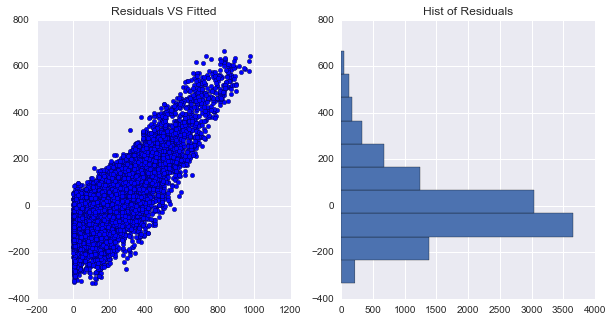

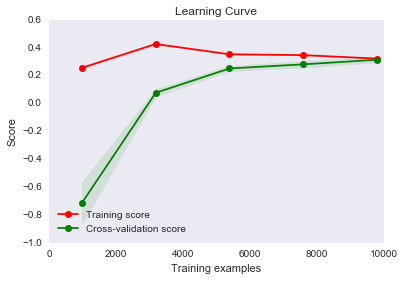

In [27]:
est = make_pipeline(PolynomialFeatures(2), StandardScaler(), Ridge())
est.fit(X, y)
score_model(X, y, est)

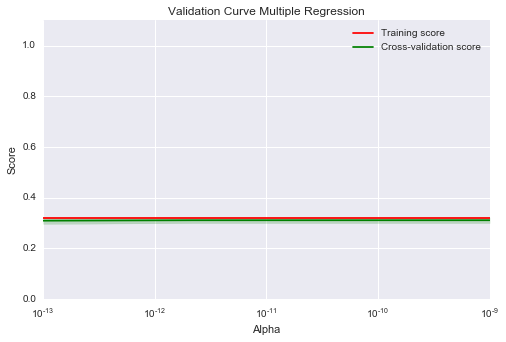

In [44]:
plot_validation_curve(X, y, est, param_range=np.logspace(-13, -9, 4))

##### Residuals are 'almost' normal, there's a bit more signal in there

# Add day of week and month to dummy variable.

In [48]:
train.join(pd.get_dummies(train.index.dayofweek, prefix='day').set_index(train.index))

,casual,registered,count,holiday,workingday,temp,atemp,humidity,windspeed,spring,...,light,clear,mist,day_0,day_1,day_2,day_3,day_4,day_5,day_6
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,3,13,16,0,0,9.84,14.395,81,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 01:00:00,8,32,40,0,0,9.02,13.635,80,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 02:00:00,5,27,32,0,0,9.02,13.635,80,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 03:00:00,3,10,13,0,0,9.84,14.395,75,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 04:00:00,0,1,1,0,0,9.84,14.395,75,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 05:00:00,0,1,1,0,0,9.84,12.880,75,6.0032,True,...,False,False,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 06:00:00,2,0,2,0,0,9.02,13.635,80,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 07:00:00,1,2,3,0,0,8.20,12.880,86,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 08:00:00,1,7,8,0,0,9.84,14.395,75,0.0000,True,...,False,True,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Let's run the models again with hours included

In [174]:
y2 = train.iloc[:, 2]
X2 = train.drop(['casual', 'registered', 'count'], axis=1)

In [175]:
est2 = make_pipeline(PolynomialFeatures(2), Ridge())

('Split Score: ', 0.82748501933338814)


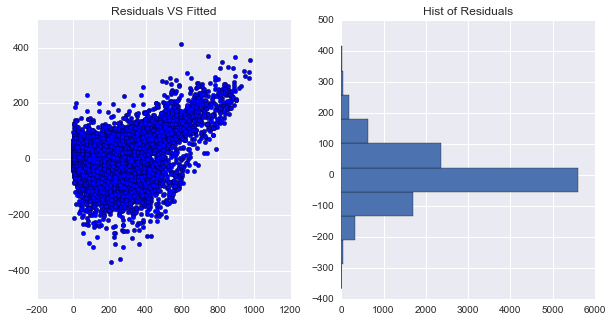

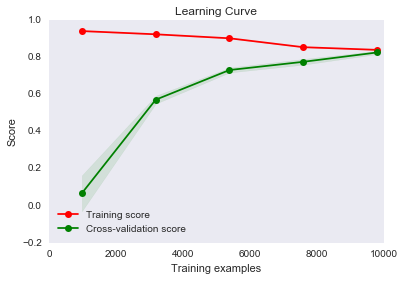

In [176]:
score_model(X2, y2, est2)

Our scores have become vastly improved by allowing for 2nd order polynomials and cross terms.  

### Evaluate performance thus far using the `validation curve` from `sklearn.learning_curve`

In [ ]:
plot_learning_curve(estimator, 'Predict Bicycle Share Usage', X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

## Feature Engineering

What other patterns are in here that we're not seeing

Looking for more signal, there might be different behaviors for different parts of the year.  

Hours and day of week

In [ ]:
train_day_hr = train.groupby([train.index.dayofweek, train.index.hour]).mean()[['casual', 'registered', 'count']]
train_day_hr.plot(xticks=range(0,6,1))

What about hours and month of year

In [ ]:
train_wkday = train[train.index.day]

In [ ]:
train_day_hr = train.groupby([train.index.weekofyear, train.index.hour]).mean()[['casual', 'registered','count']]
train_day_hr.plot(xticks=range(0,6,1))

In [ ]:
train = train.join(pd.get_dummies(train.index.weekofyear, prefix='wk').set_index(train.index))
train.index = pd.to_datetime(train.index)

In [ ]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
est = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
est.fit(X_train,y_train)

y_pred = est.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)

In [ ]:
est.score(X_test,y_test), est.score(X_train, y_train)

In [216]:
estimator = make_pipeline(PolynomialFeatures(2), StandardScaler(), Ridge())

In [224]:
param_range = np.logspace(-15, 3, 6)
train_scores, test_scores = validation_curve(
    estimator, X2, y2, param_name='ridge__alpha',
    param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

plt.title("Validation Curve with Multiple Regression")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

TypeError: Expected sequence or array-like, got estimator Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0000000000000001e-15, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001))])

In [ ]:
plot_learning_curve(estimator, 'Predict Bicycle Share Usage', X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

In [283]:
cross_val_score(estimator, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

array([  2.93520896e-01,   3.12221903e-01,   2.88365427e-01,
         3.09778427e-01,   3.15349284e-01,   2.97713628e-01,
        -7.59290263e+02,   3.62982270e-01,   3.12275185e-01,
         2.95984454e-01])

In [ ]:
results = estimator.fit(X,y)

In [ ]:
estimator.score(X,y)

In [255]:
a = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 1], [2, 1], [1, 0]])
b = np.array([1, 2, 3, 4, 5, 6, 7])

In [279]:
kf = KFold(a.shape[0], n_folds=3, shuffle=True)

In [ ]:
for train_index, test_index in kf:
    print ("TRAIN:", train_index, "TEST:", test_index)
    a_train, a_test = a[train_index], a[test_index]
    b_train, b_test = b[train_index], y[test_index]


# Maybe use maybe not

''

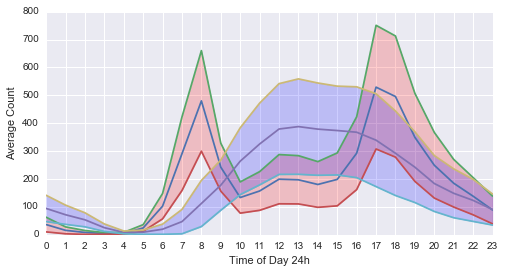

In [96]:
plt.figure(figsize=(8, 4))
plt.plot(train_hours.drop(['registered', 'casual', 'count_stdev'], axis=1))
plt.fill_between(train_hours.index, train_hours['count-stdev'],
                 train_hours['count+stdev'], alpha=0.1, 
                                                    color="r")
plt.fill_between(train_hours.index, train_hours['count-stdev'],
                 train_hours['count+stdev'], alpha=0.1, 
                                                    color="r")
plt.xticks(range(0, 24, 1))
plt.ylim(0, 800)

### Second Plot

plt.plot(train_wknd_hours.drop(['registered', 'casual', 'count_stdev'], axis=1))
plt.fill_between(train_wknd_hours.index, train_wknd_hours['count-stdev'],
                 train_wknd_hours['count+stdev'], alpha=0.1, 
                                                    color="b")
plt.fill_between(train_wknd_hours.index, train_wknd_hours['count-stdev'],
                 train_wknd_hours['count+stdev'], alpha=0.1, 
                                                    color="b")
plt.xticks(range(0, 24, 1))
plt.ylim(0,800)

plt.ylabel('Average Count')
plt.xlabel('Time of Day 24h')
;